# EMA of Curacao EV Vensim Model - FINAL EXPERIMENTS

In this Jupyter Notebook:
1. Set uo initial experiment [of n=1500 using all 39 uncertainties]
2. Initial Exploration
3. Random Forest to reduce amount of uncertainties from 39 > 10
4. Re-run experiment for 12 policy combinations and 10 uncertainties
5. Perform PRIM Scenario discovery on new, smaller dataset

In [1]:
# --- Environment & library setup (clean) 
# ~6 seconds to run

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ema_workbench import (
    RealParameter,
    IntegerParameter,
    CategoricalParameter,
    Constant,
    TimeSeriesOutcome,
    perform_experiments,
    save_results,
    load_results,
    ema_logging,
)
from ema_workbench.connectors.vensim import VensimModel
from ema_workbench.analysis import prim, feature_scoring, pairs_plotting, plotting

def print_versions() -> None:
    """Print key environment versions and paths (direct, compact)."""
    import ema_workbench  # local import to avoid polluting top-level namespace

    print(f"EMA version : {ema_workbench.__version__}")
    print(f"EMA path    : {ema_workbench.__file__}")
    print(f"NumPy       : {np.__version__}")
    print(f"Python exe  : {sys.executable}")

# Fix for older numpy versions that do not have np.NAN 
import numpy as np 
if not hasattr(np, "NAN"): np.NAN = np.nan

if __name__ == "__main__":
    ema_logging.log_to_stderr(ema_logging.INFO)
    print_versions()


c:\Users\Amber Rozenberg\anaconda3\envs\cura_ev_env\Lib\site-packages\ema_workbench\connectors\__init__.py:29: ImportWarning: netlogo connector not available
  warnings.warn("netlogo connector not available", ImportWarning)
c:\Users\Amber Rozenberg\anaconda3\envs\cura_ev_env\Lib\site-packages\ema_workbench\connectors\__init__.py:34: ImportWarning: simio connector not available
  warnings.warn("simio connector not available", ImportWarning)


EMA version : 2.5.3
EMA path    : c:\Users\Amber Rozenberg\anaconda3\envs\cura_ev_env\Lib\site-packages\ema_workbench\__init__.py
NumPy       : 2.3.3
Python exe  : c:\Users\Amber Rozenberg\anaconda3\envs\cura_ev_env\python.exe


## 1. Set up Initial Experiment

In [2]:
# EXPERIMENTAL SETUP OPEN EXPLORATION
# turn on logging
ema_logging.log_to_stderr(ema_logging.INFO) 

# instantiate a model
wd = "./model_files/" # adjust this path to load different version of model
vensim_model = VensimModel("evmodel", wd=wd, model_file="ev_curacao_model.vpmx") # "21-10 ochtend.vpmx" "20-10 eind middag.vpmx"

uncertainties = [
    # ----------------------------
    # Categorical switches
    # ----------------------------
    CategoricalParameter("Energy price switch", (1, 2, 3)),                         # 1=Stanford, 2=Twente, 3=IET
    CategoricalParameter("Fuel price switch", (1, 2, 3)),                           # 1=high, 2=medium, 3=low
    CategoricalParameter("market price scenario switch", (0, 1, 2)),                # 0=, 1=, 2=

    # --- Initial conditions Cars/EVs
    IntegerParameter("initial total cars", int(78717*0.95), int(78717*1.05)),       # 78717 ±20%
    RealParameter("initial share of EV", 0.0254075*0.9, 0.0254075*1.1),             # 

    # --- CO2 initial levels (FossilVehicle only; EV kept constant at 0)
    RealParameter("initial CO2 0 to 5 yrs[FossilVehicle]", 92, 138),                # 115 ±20%
    RealParameter("initial CO2 5 to 10 yrs[FossilVehicle]", 120, 180),              # 150 ±20%
    RealParameter("initial CO2 10 to 15 yrs[FossilVehicle]", 136, 204),             # 170 ±20%
    RealParameter("initial CO2 15 to 20 yrs[FossilVehicle]", 144, 216),             # 180 ±20%
    RealParameter("initial CO2 20 yrs plus[FossilVehicle]", 152, 228),              # 190 ±20%

    # --- Prices & costs
    RealParameter("operational", 0.3129*0.5, 0.3129*1.5),                           # 0.3129 ±50%
    RealParameter("yearly fee", 343*0.5, 343*1.5),                                  # 343 ±50%
  
    # --- Efficiency / kms driven / growth
    RealParameter("fuel efficiency", 0.11235*0.8, 0.11235*1.2),                             # (1/8.9) ±20% 
    RealParameter("Average kms driven anually[FossilVehicle]", 10000*0.7, 10000*1.3),       # 10000 ±20%
    RealParameter("Average kms driven anually[ElectricVehicle]", 10000*0.7, 10000*1.3),     # 10000 ±20%
    RealParameter('"Car park growth %"', 0.0212*0.5, 0.0212*1.1),                           # 0.0212 -50%, +10%

    # --- Charging infrastructure (constants-only items)
    RealParameter("initial value facilities[FossilVehicle]", 35*0.9, 35*1.1),       # 35 ±20%
    RealParameter("initial value facilities[ElectricVehicle]", 32*0.8, 32*1.2),     # 32 ±20%
    RealParameter("facility ratio[FossilVehicle]", 0.002*0.9, 0.002*1.1),           # 
    RealParameter("facility ratio[ElectricVehicle]", 0.2*0.5, 0.2*1.1),             # 
    RealParameter("Facility delay[FossilVehicle]", 1.5*0.7, 1.5*1.3),               # 0.9 ±20%
    RealParameter("Facility delay[ElectricVehicle]", 0.5*0.7, 1.5*0.7),             # 0.7 ±20%

    # --- Discrete choice (ASC & betas)
    RealParameter("ASC[FossilVehicle]", 0.9*0.8, 0.9*1.2),                          # 0.9 ±20%
    RealParameter("ASC[ElectricVehicle]", 0.1*0.8, 0.1*1.2),                        # 0.1 ±20%
    RealParameter("beta range", 0.00166, 0.00328),                                  # 95% confidence interval from SDC
    RealParameter("beta charging distance", -0.5, -0.06),                           #  95% confidence interval from SDC
    RealParameter("beta charge time", -0.0021, -0.00041),                           # 95% confidence interval from SDC
    RealParameter('"beta fuel/charging costs"', -0.00351, -0.00191),                # (-0.271/100) ±20% 
    RealParameter("beta car price", -5.06e-05*1.5, -5.06e-05*0.5),                  # (-7.59e-05, -2.53e-05)
    
    # --- Out-of-use rates (both vehicle types)
    RealParameter('"out of use % 0 to 5 yr"[FossilVehicle]', 0.0152, 0.0228),       # 0.019 ±20%
    RealParameter('"out of use % 5 to10 yr"[FossilVehicle]', 0.0184, 0.0276),       # 0.023 ±20%
    RealParameter('"out of use % 10 to15 yr"[FossilVehicle]', 0.0408, 0.0612),      # 0.051 ±20%
    RealParameter('"out of use % 15 to 20 yr"[FossilVehicle]', 0.1296, 0.1944),     # 0.162 ±20%
    RealParameter('"out of use % 20 yr plus"[FossilVehicle]', 0.112, 0.168),        # 0.14 ±20%

    RealParameter('"out of use % 0 to 5 yr"[ElectricVehicle]', 0.0152, 0.0228),     #
    RealParameter('"out of use % 5 to10 yr"[ElectricVehicle]', 0.0184, 0.0276),     #
    RealParameter('"out of use % 10 to15 yr"[ElectricVehicle]', 0.0408, 0.0612),    #
    RealParameter('"out of use % 15 to 20 yr"[ElectricVehicle]', 0.1296, 0.1944),   #
    RealParameter('"out of use % 20 yr plus"[ElectricVehicle]', 0.112, 0.168),      #
]

# Define policies as constants for initial run
constants = [
    # Constants can be defined here if needed
    Constant("Emission tax SWITCH", 0),
    Constant("SWITCH Policy EV Tax Cut", 0),
    Constant("Dynaf lever SWITCH", 0),  
]

# Register on the model
vensim_model.uncertainties = uncertainties 
vensim_model.constants = constants

vensim_model.outcomes = [
    TimeSeriesOutcome("Number of EVs"),
    TimeSeriesOutcome("Total CO2 emissions cars[FossilVehicle]"),
    TimeSeriesOutcome("Number of FossilVehicles"),
    ]
 
# RUN THE EXPERIMENTS
results = perform_experiments(vensim_model, 
                              scenarios=1500#,
                              #policies=7
                              )

# split results into experiments and outcomes
experiments, outcomes = results

[MainProcess/INFO] performing 1500 scenarios * 1 policies * 1 model(s) = 1500 experiments
100%|██████████████████████████████████████| 1500/1500 [00:57<00:00, 25.98it/s]
[MainProcess/INFO] experiments finished


#### Save/load results [comment out if not necessary]

In [3]:
# Save results  
save_results(results, "./results/results_no_POLICY.tar.gz")

c:\Users\Amber Rozenberg\anaconda3\envs\cura_ev_env\Lib\site-packages\ema_workbench\em_framework\outcomes.py:541: UserWarning: still to be tested!!
  warnings.warn("still to be tested!!")
[MainProcess/INFO] results saved successfully to c:\Users\Amber Rozenberg\Documents\0. Julia\Curacao EV\curacao_ev\results\results_no_POLICY.tar.gz


In [4]:
# Load results
#experiments, outcomes = load_results("./results/results_no_POLICY.tar.gz")

## 2. Initial Exploration

### Pairplot

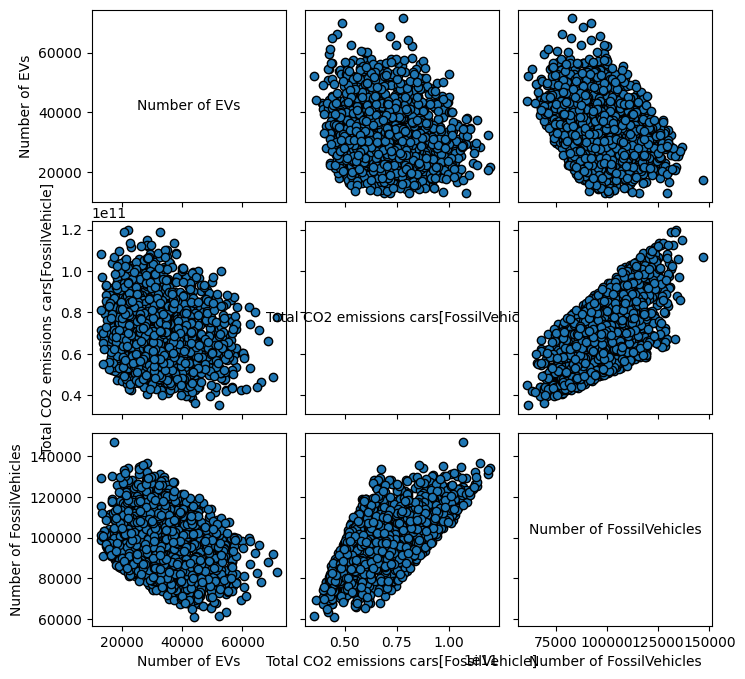

In [5]:
fig, axes = pairs_plotting.pairs_scatter(
    experiments, outcomes, legend=False
)
fig.set_size_inches(8, 8)
plt.show()

### Runs Overview

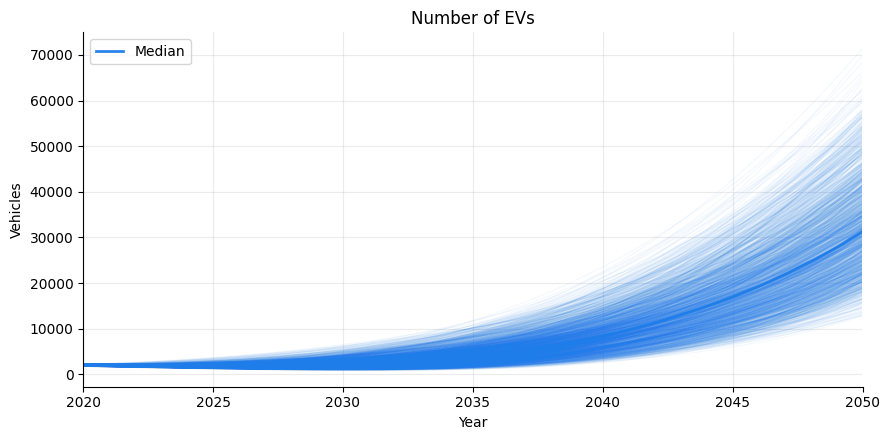

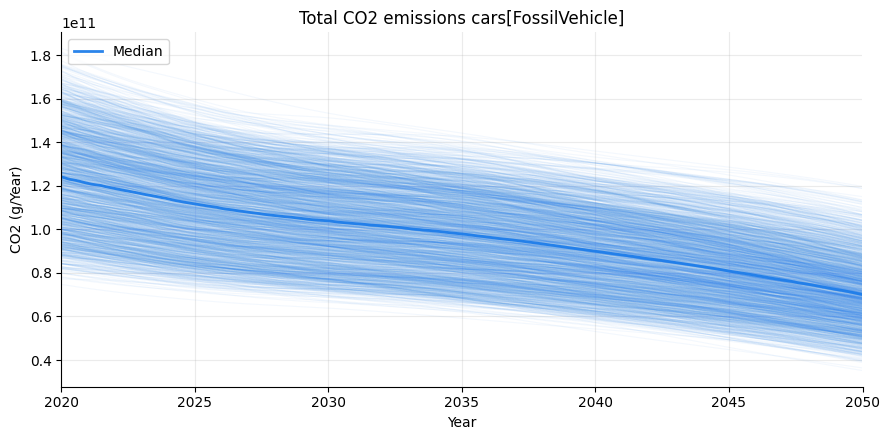

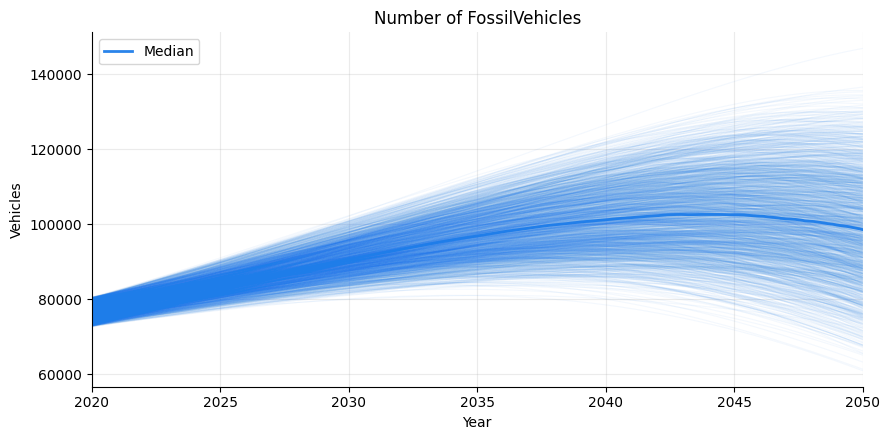

In [6]:
outcomes_of_interest = [
    "Number of EVs",
    "Total CO2 emissions cars[FossilVehicle]",
    "Number of FossilVehicles",
]

# units (adjust if needed)
units = {
    "Number of EVs": "Vehicles",
    "Total CO2 emissions cars[FossilVehicle]": "CO2 (g/Year)",
    "Number of FossilVehicles": "Vehicles",
}

def _make_time_axis_from_outcome(arr):
    T = arr.shape[1]
    for key in ("time", "TIME", "Time"):
        if key in outcomes and getattr(outcomes[key], "ndim", None) == 1 and outcomes[key].shape[0] == T:
            return outcomes[key]
    # default: inclusive years 2020..2050 mapped to T points
    return np.linspace(2020, 2050, T)

def plot_many_runs_same_colour(outcomes, outcome_names,
                               units=None,
                               upsample_factor=8,
                               base_color="#1f77b4",
                               line_alpha=0.03,
                               lw=0.8,
                               show_median=True,
                               figsize=(9, 4.5)):
    """
    Plot each outcome in outcomes_of_interest as an individual figure.
    Lines use the same colour and a low alpha so overlapping areas become brighter.
    Linear interpolation upsamples the series to smooth step-like (rectangular) data.
    """
    for outcome_name in outcome_names:
        if outcome_name not in outcomes:
            print(f"Warning: outcome '{outcome_name}' not found. Skipping.")
            continue

        arr = outcomes[outcome_name]  # expected shape (n_cases, T)
        if arr.ndim != 2:
            raise ValueError(f"Outcome '{outcome_name}' must be 2D (n_cases, T); got {arr.shape}")

        n_cases, T = arr.shape
        time = _make_time_axis_from_outcome(arr)
        # build a finer time axis for interpolation
        fine_T = int(T * upsample_factor)
        fine_time = np.linspace(time[0], time[-1], fine_T)

        fig, ax = plt.subplots(figsize=figsize)

        # plot each run interpolated to fine_time
        for i in range(n_cases):
            y = arr[i, :].astype(float)
            y_fine = np.interp(fine_time, time, y)   # linear interpolation
            ax.plot(fine_time, y_fine, color=base_color, alpha=line_alpha, linewidth=lw, solid_capstyle="round")

        # median overlay
        if show_median:
            median = np.nanmedian(arr, axis=0)
            median_fine = np.interp(fine_time, time, median)
            ax.plot(fine_time, median_fine, color=base_color, linewidth=2.0, alpha=0.95, label="Median")

        ax.set_title(outcome_name)
        ax.set_xlabel("Year")
        ax.set_ylabel(units.get(outcome_name, "Value") if units else "Value")
        ax.set_xlim(2020, 2050)
        ax.set_xticks(np.arange(2020, 2051, 5))
        ax.grid(alpha=0.25)
        if show_median:
            ax.legend(loc="upper left")
        plt.tight_layout()
        sns.despine()
        plt.show()

# Call the improved plotter (adjust parameters if you want different smoothing/alpha)
plot_many_runs_same_colour(outcomes, outcomes_of_interest, units=units,
                           upsample_factor=8, base_color="#1e7de9", line_alpha=0.05, lw=0.8)

(<Figure size 640x480 with 6 Axes>,
 {'Number of EVs': <Axes: xlabel='time', ylabel='Number of EVs'>,
  'Total CO2 emissions cars[FossilVehicle]': <Axes: xlabel='time', ylabel='Total CO2 emissions cars[FossilVehicle]'>,
  'Number of FossilVehicles': <Axes: xlabel='time', ylabel='Number of FossilVehicles'>})

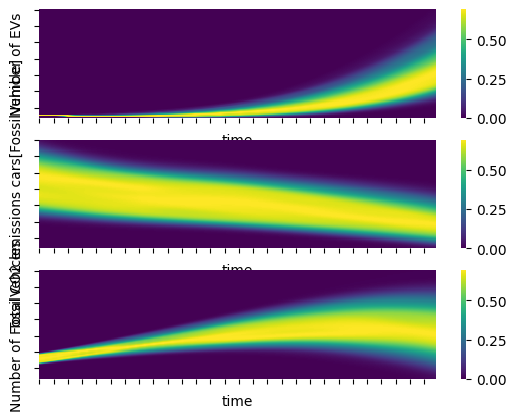

In [7]:
# KDE over time
plotting.kde_over_time(experiments, outcomes, 
                       outcomes_to_show=None, 
                       group_by=None, grouping_specifiers=None, 
                       colormap='viridis', log=True)


## 3. Random Forest

### FOR EV IN 2050

In [8]:
# Pull out the time series from EMA outcomes
ev_ts = np.array(outcomes["Number of EVs"])

# Select the last time step (2050)
ev_final = ev_ts[:, -1]

# Drop non-input columns
X = experiments.drop(columns=["scenario", "policy", "model"], errors="ignore")

# Define target
y = ev_final

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

In [10]:
# perform RandomForest (impurity and permutation importance)
rf = RandomForestRegressor(
    n_estimators=500,
    random_state=42,
    n_jobs=-1
)
rf.fit(X, y)

# impurity-based quick check
impurity_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Top features (impurity-based):")
print(impurity_importances.head(15))

# permutation importance (more reliable)
perm = permutation_importance(rf, X, y, n_repeats=10, random_state=42, n_jobs=-1)
perm_importances = pd.Series(perm.importances_mean, index=X.columns).sort_values(ascending=False)

print("\nTop features (permutation-based):")
print(perm_importances.head(15))

Top features (impurity-based):
market price scenario switch                 0.266059
beta car price                               0.260499
"Car park growth %"                          0.167511
beta charge time                             0.109392
ASC[FossilVehicle]                           0.042600
beta range                                   0.038515
beta charging distance                       0.011594
initial value facilities[ElectricVehicle]    0.009392
initial value facilities[FossilVehicle]      0.005080
initial total cars                           0.004655
"out of use % 5 to10 yr"[FossilVehicle]      0.004010
"out of use % 20 yr plus"[FossilVehicle]     0.003695
operational                                  0.003676
ASC[ElectricVehicle]                         0.003583
facility ratio[ElectricVehicle]              0.003479
dtype: float64

Top features (permutation-based):
market price scenario switch                 0.626237
beta car price                               0.527576
"

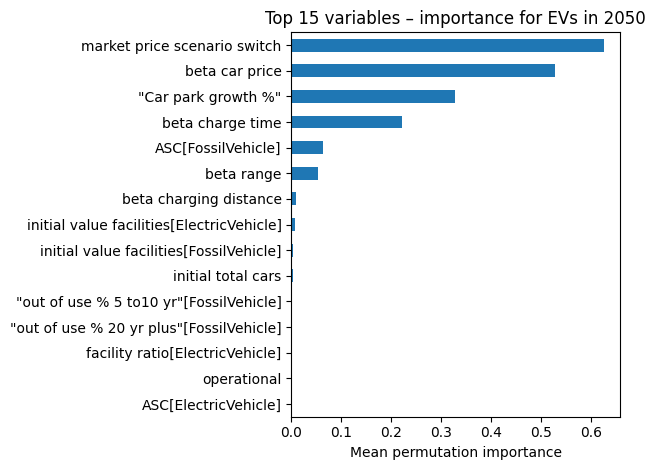

In [11]:
# plot permutation importances
perm_importances.head(15).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top 15 variables – importance for EVs in 2050")
plt.xlabel("Mean permutation importance")
plt.tight_layout()
plt.show()


## 4. Re-Run with fewer uncertainties and policies

### FOR EV IN 2050

In [16]:
# instantiate a model
wd = "./model_files/" # adjust this path to load different version of model
vensim_model = VensimModel("evmodel", wd=wd, model_file="ev_curacao_model.vpmx") # "21-10 ochtend.vpmx" "20-10 eind middag.vpmx"

uncertainties = [
    # ----------------------------
    # Categorical switches
    # ----------------------------
#    CategoricalParameter("Energy price switch", (1, 2, 3)),                         # 1=Stanford, 2=Twente, 3=IET
#    CategoricalParameter("Fuel price switch", (1, 2, 3)),                           # 1=high, 2=medium, 3=low
    CategoricalParameter("market price scenario switch", (0, 1, 2)),                # 0=, 1=, 2=

    # --- Initial conditions Cars/EVs
    IntegerParameter("initial total cars", int(78717*0.95), int(78717*1.05)),       # 78717 ±20%
#    RealParameter("initial share of EV", 0.0254075*0.9, 0.0254075*1.1),             # 

    # --- CO2 initial levels (FossilVehicle only; EV kept constant at 0)
#    RealParameter("initial CO2 0 to 5 yrs[FossilVehicle]", 92, 138),                # 115 ±20%
#    RealParameter("initial CO2 5 to 10 yrs[FossilVehicle]", 120, 180),              # 150 ±20%
#    RealParameter("initial CO2 10 to 15 yrs[FossilVehicle]", 136, 204),             # 170 ±20%
#    RealParameter("initial CO2 15 to 20 yrs[FossilVehicle]", 144, 216),             # 180 ±20%
#    RealParameter("initial CO2 20 yrs plus[FossilVehicle]", 152, 228),              # 190 ±20%

    # --- Prices & costs
#    RealParameter("operational", 0.3129*0.5, 0.3129*1.5),                           # 0.3129 ±50%
#    RealParameter("yearly fee", 343*0.5, 343*1.5),                                  # 343 ±50%
  
    # --- Efficiency / kms driven / growth
#    RealParameter("fuel efficiency", 0.11235*0.8, 0.11235*1.2),                             # (1/8.9) ±20% 
#    RealParameter("Average kms driven anually[FossilVehicle]", 10000*0.7, 10000*1.3),       # 10000 ±20%
#    RealParameter("Average kms driven anually[ElectricVehicle]", 10000*0.7, 10000*1.3),     # 10000 ±20%
    RealParameter('"Car park growth %"', 0.0212*0.5, 0.0212*1.1),                           # 0.0212 -50%, +10%

    # --- Charging infrastructure (constants-only items)
#    RealParameter("initial value facilities[FossilVehicle]", 35*0.9, 35*1.1),       # 35 ±20%
#    RealParameter("initial value facilities[ElectricVehicle]", 32*0.8, 32*1.2),     # 32 ±20%
#    RealParameter("facility ratio[FossilVehicle]", 0.002*0.9, 0.002*1.1),           # 
#    RealParameter("facility ratio[ElectricVehicle]", 0.2*0.5, 0.2*1.1),             # 
#    RealParameter("Facility delay[FossilVehicle]", 1.5*0.7, 1.5*1.3),               # 0.9 ±20%
#    RealParameter("Facility delay[ElectricVehicle]", 0.5*0.7, 1.5*0.7),             # 0.7 ±20%

    # --- Discrete choice (ASC & betas)
    RealParameter("ASC[FossilVehicle]", 0.9*0.8, 0.9*1.2),                          # 0.9 ±20%
#    RealParameter("ASC[ElectricVehicle]", 0.1*0.8, 0.1*1.2),                        # 0.1 ±20%
    RealParameter("beta range", 0.00166, 0.00328),                                  # 95% confidence interval from SDC
    RealParameter("beta charging distance", -0.5, -0.06),                           #  95% confidence interval from SDC
    RealParameter("beta charge time", -0.0021, -0.00041),                           # 95% confidence interval from SDC
#    RealParameter('"beta fuel/charging costs"', -0.00351, -0.00191),                # (-0.271/100) ±20% 
    RealParameter("beta car price", -5.06e-05*1.5, -5.06e-05*0.5),                  # (-7.59e-05, -2.53e-05)
    
    # --- Out-of-use rates (both vehicle types)
#    RealParameter('"out of use % 0 to 5 yr"[FossilVehicle]', 0.0152, 0.0228),       # 0.019 ±20%
#    RealParameter('"out of use % 5 to10 yr"[FossilVehicle]', 0.0184, 0.0276),       # 0.023 ±20%
#    RealParameter('"out of use % 10 to15 yr"[FossilVehicle]', 0.0408, 0.0612),      # 0.051 ±20%
#    RealParameter('"out of use % 15 to 20 yr"[FossilVehicle]', 0.1296, 0.1944),     # 0.162 ±20%
#    RealParameter('"out of use % 20 yr plus"[FossilVehicle]', 0.112, 0.168),        # 0.14 ±20%

#    RealParameter('"out of use % 0 to 5 yr"[ElectricVehicle]', 0.0152, 0.0228),     #
#    RealParameter('"out of use % 5 to10 yr"[ElectricVehicle]', 0.0184, 0.0276),     #
#    RealParameter('"out of use % 10 to15 yr"[ElectricVehicle]', 0.0408, 0.0612),    #
#    RealParameter('"out of use % 15 to 20 yr"[ElectricVehicle]', 0.1296, 0.1944),   #
#    RealParameter('"out of use % 20 yr plus"[ElectricVehicle]', 0.112, 0.168),      #
]

policy_levers = [
    CategoricalParameter("Emission tax SWITCH", (0, 1)),        #
    CategoricalParameter("SWITCH Policy EV Tax Cut", (0, 1)),   #
   CategoricalParameter("Dynaf lever SWITCH", (0, 1, 2)),      # 0=normal,1=high,2=very high
]

# Register on the model
vensim_model.uncertainties = uncertainties #+ policy_levers
vensim_model.levers = policy_levers 

vensim_model.outcomes = [
    TimeSeriesOutcome("Number of EVs"),
    TimeSeriesOutcome("Total CO2 emissions cars[FossilVehicle]"),
    TimeSeriesOutcome("Number of FossilVehicles"),
    ]
 
# RUN THE EXPERIMENTS
results = perform_experiments(vensim_model, 
                              scenarios=200,
                              policies=12
                              )

# split results into experiments and outcomes
experiments, outcomes = results

[MainProcess/INFO] performing 200 scenarios * 12 policies * 1 model(s) = 2400 experiments
  0%|                                                 | 0/2400 [00:00<?, ?it/s][MainProcess/INFO] performing experiments sequentially


100%|██████████████████████████████████████| 2400/2400 [01:30<00:00, 26.40it/s]
[MainProcess/INFO] experiments finished


In [17]:
experiments.head()

"Car park growth %"  ASC[FossilVehicle]  beta car price  beta charge time  \
0             0.012786            0.951949       -0.000051         -0.000885   
1             0.021090            0.725046       -0.000031         -0.001259   
2             0.013918            0.801306       -0.000034         -0.001039   
3             0.017897            0.965011       -0.000068         -0.000680   
4             0.010933            0.924815       -0.000046         -0.001452   

   beta charging distance  beta range  initial total cars  \
0               -0.216018    0.002209               76152   
1               -0.206953    0.003205               77411   
2               -0.328129    0.002328               79381   
3               -0.072082    0.001995               80519   
4               -0.183328    0.001717               81052   

  market price scenario switch Dynaf lever SWITCH Emission tax SWITCH  \
0                            0                  1                   1   
1                            0                  1                   1   
2                            2                  1                   1   
3                            1                  1                   1   
4                            1                  1                   1   

  SWITCH Policy EV Tax Cut scenario policy    model  
0                        1     1724   1712  evmodel  
1                        1     1725   1712  evmodel  
2                        1     1726   1712  evmodel  
3                        1     1727   1712  evmodel  
4                        1     1728   1712  evmodel

In [18]:
# Save results  
save_results(results, "./results/results_PRIM_WITH_POLICY.tar.gz")

c:\Users\Amber Rozenberg\anaconda3\envs\cura_ev_env\Lib\site-packages\ema_workbench\em_framework\outcomes.py:541: UserWarning: still to be tested!!
  warnings.warn("still to be tested!!")
[MainProcess/INFO] results saved successfully to c:\Users\Amber Rozenberg\Documents\0. Julia\Curacao EV\curacao_ev\results\results_PRIM_WITH_POLICY.tar.gz


In [ ]:
# Load results
#experiments, outcomes = load_results("./results/results_PRIM_WITH_POLICY.tar.gz")

### Initial Exploration

C:\Users\Amber Rozenberg\AppData\Local\Temp\ipykernel_8504\3169163440.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend(
C:\Users\Amber Rozenberg\AppData\Local\Temp\ipykernel_8504\3169163440.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])  # leave space for legend


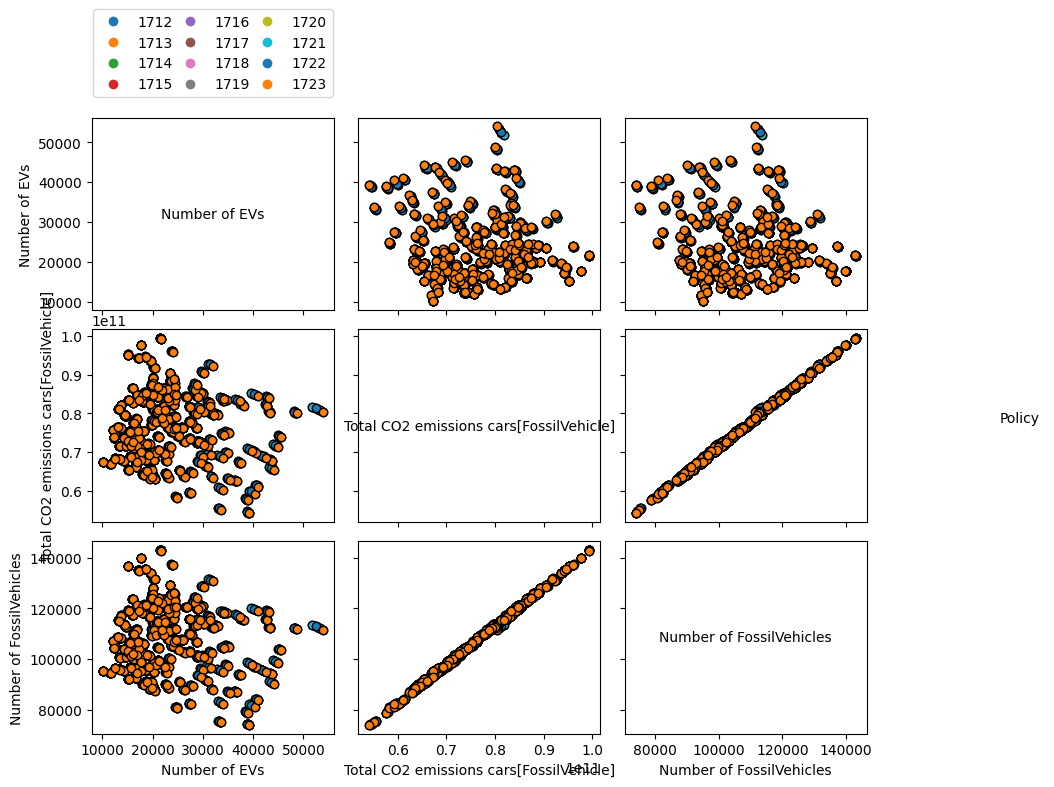

In [27]:
# Initial Exploration, colour-coded by policy?
fig, axes = pairs_plotting.pairs_scatter(
    experiments, outcomes, legend=True, group_by='policy', 
    alpha=0.3, s=10,
)
fig.set_size_inches(8, 8)

fig.legend(
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    title='Policy',
    frameon=False,
)
fig.set_size_inches(10, 8)
plt.tight_layout(rect=[0, 0, 0.85, 1])  # leave space for legend

plt.show()

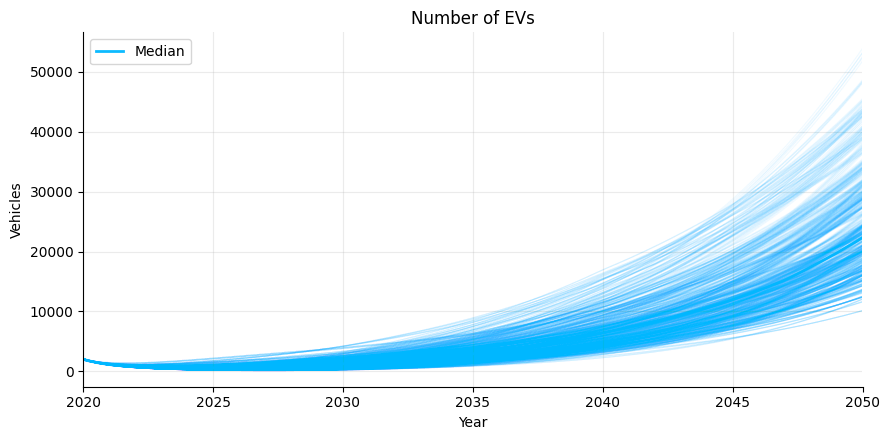

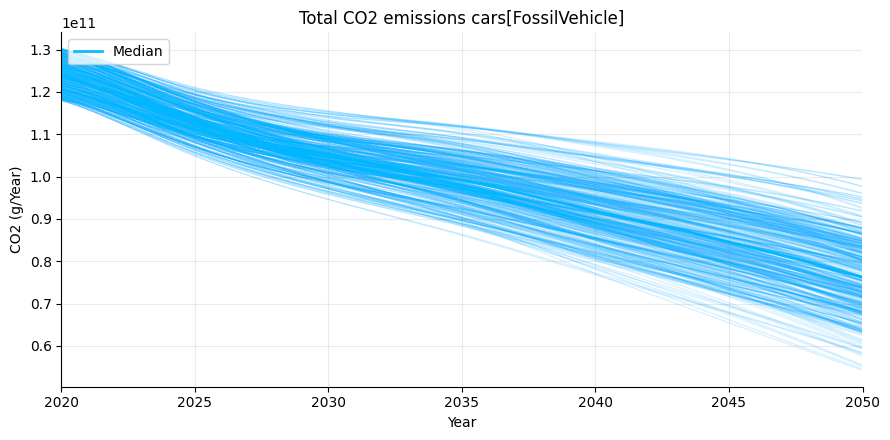

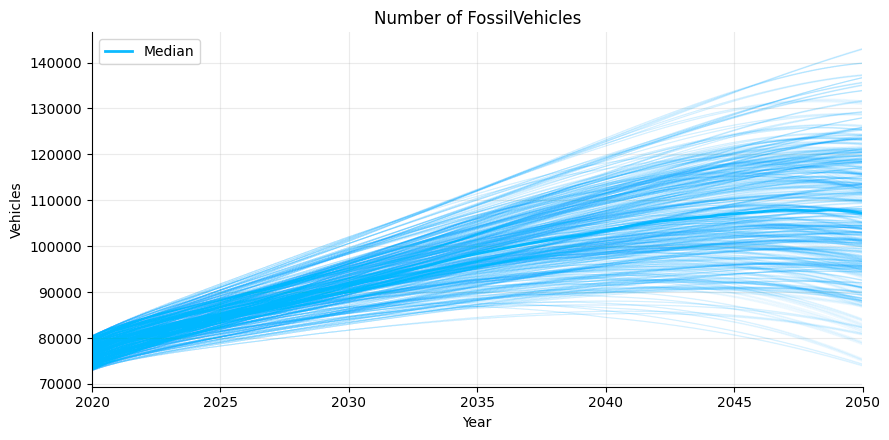

In [ ]:
# plot the outcomes of interest as line graphs
plot_many_runs_same_colour(outcomes, outcomes_of_interest, units=units,
                           upsample_factor=8, base_color="#00B7FF", line_alpha=0.03, lw=0.8)

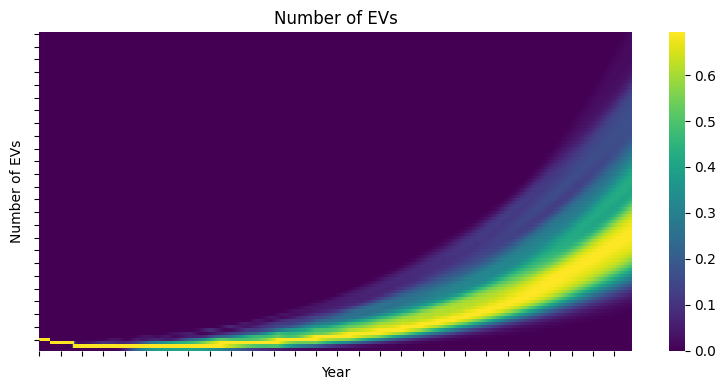

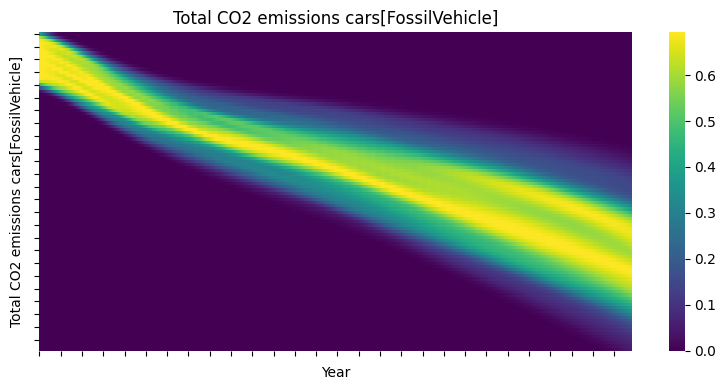

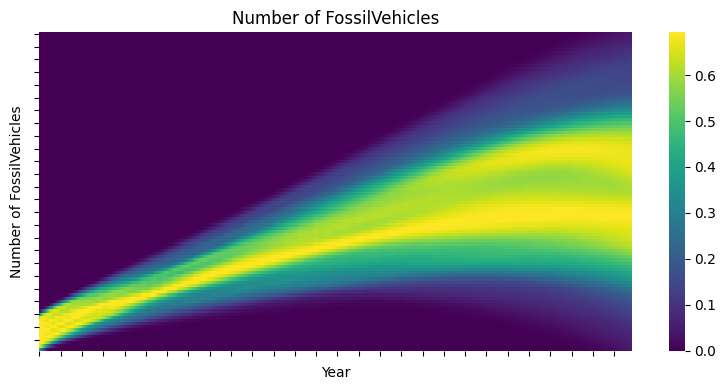

In [33]:
for out in ["Number of EVs", "Total CO2 emissions cars[FossilVehicle]", "Number of FossilVehicles"]:
    fig, axes = plotting.kde_over_time(
        experiments, outcomes,
        outcomes_to_show=[out],
        colormap='viridis',
        log=True
    )

    ax = axes[out]   # extract the subplot
    ax.set_xlabel("Year")

    ax.set_title(out)
    fig.set_size_inches(8, 4)
    plt.tight_layout()
    plt.show()


## 5. Scenario Discovery

### Patient-Rule Induction Method (PRIM)

#### LOW EV SCENARIO

In [ ]:
x = experiments

ev_ts = outcomes["Number of EVs"]
final_evs = ev_ts[:, -1] # pick the last time step (or the column == 30 if your columns are time labels)

cutoff_lo = np.percentile(final_evs, 20)   # 20th percentile
y = final_evs < cutoff_lo                  # explicitly asking PRIM to find combinations of inputs that characterise low EV adoption scenarios.

In [35]:
prim_alg = prim.Prim(x, y, threshold=0.8)
box1 = prim_alg.find_box()

[MainProcess/INFO] column model dropped from analysis because it has only one category
[MainProcess/INFO] 2400 points remaining, containing 480 cases of interest
[MainProcess/INFO] mean: 0.95, mass: 0.1, coverage: 0.475, density: 0.95 restricted_dimensions: 5


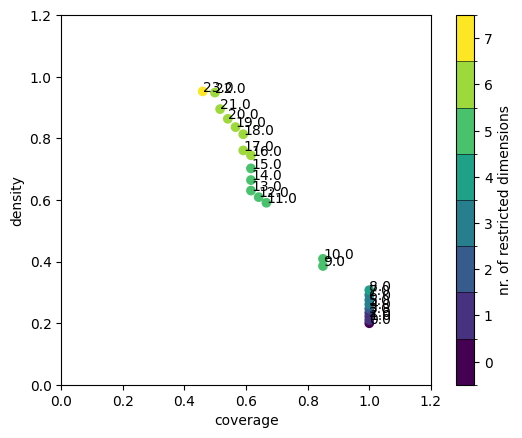

In [19]:
box1.show_tradeoff(annotated=True)
plt.show()

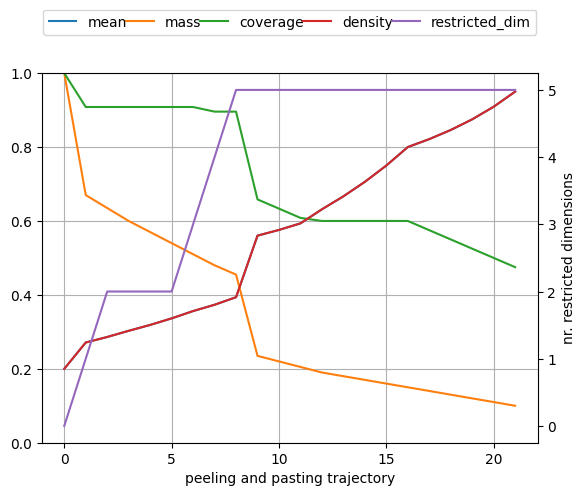

In [39]:
box1.show_ppt() ;

''

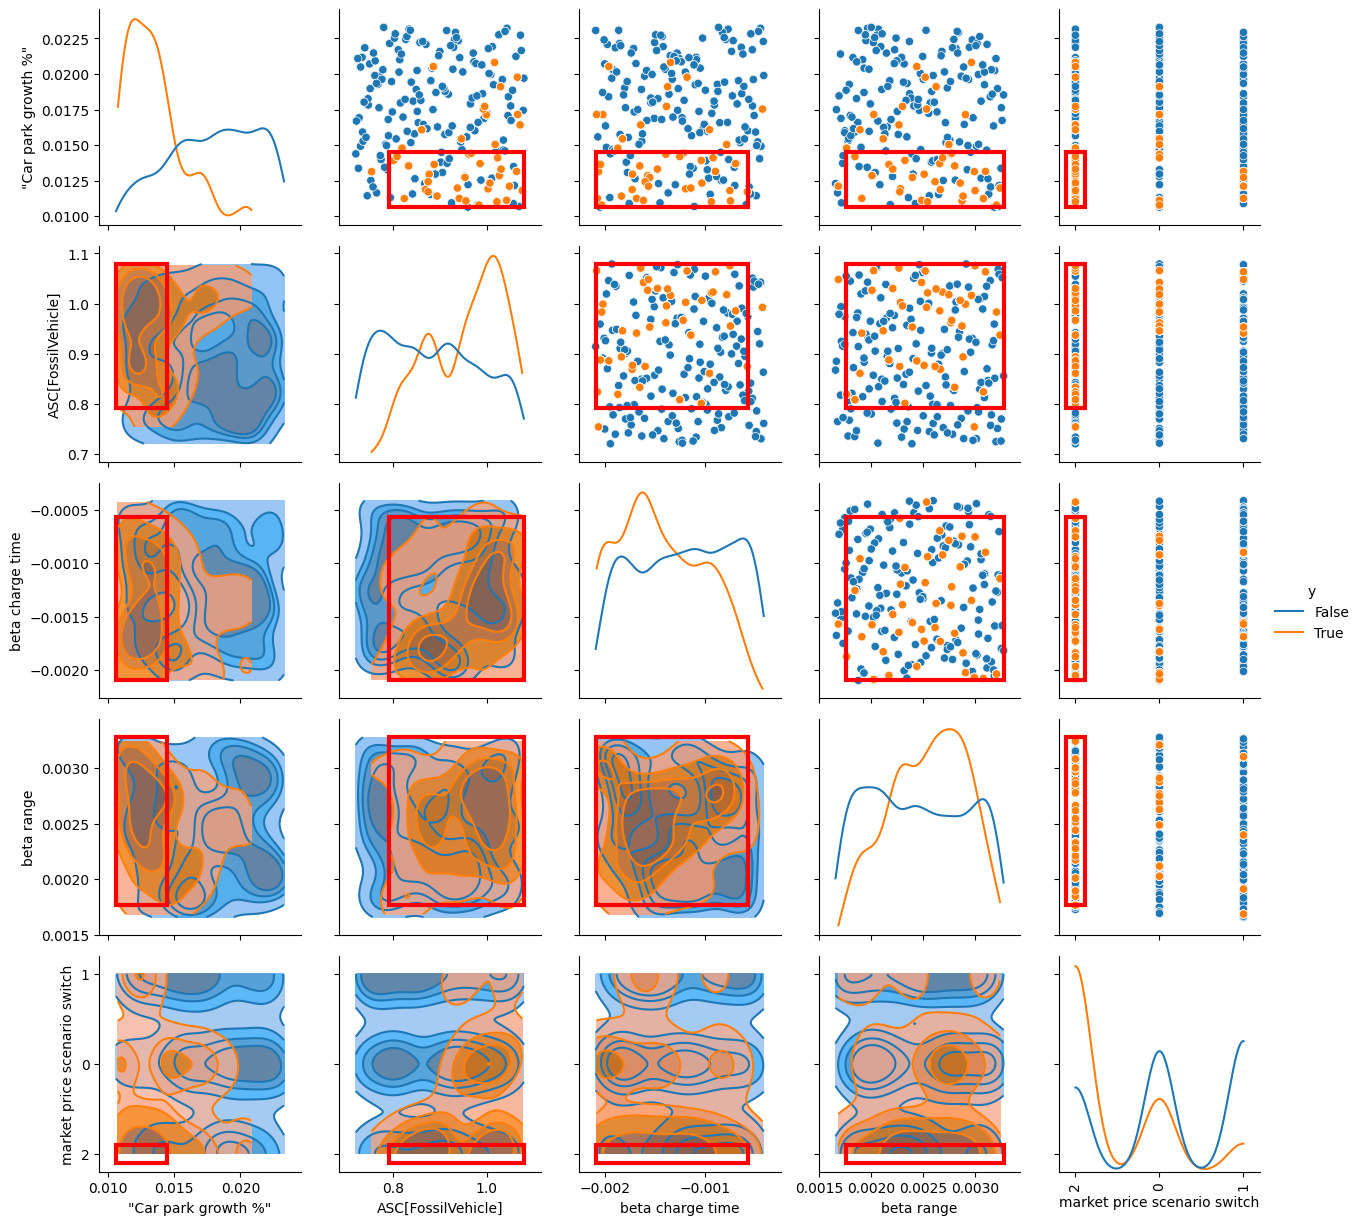

In [41]:
# Scatter plot of box boundaries, for n=2400 takes ~ 1 min
box1.show_pairs_scatter()        # visualize relationships inside/outside box
;

coverage      0.60
density       0.80
id           16.00
k           288.00
mass          0.15
mean          0.80
n           360.00
res_dim       5.00
Name: 16, dtype: float64

                                box 16                                      
                                   min       max      qp value      qp value
"Car park growth %"           0.010633  0.017904           NaN  2.176456e-34
beta charge time             -0.002094 -0.000569           NaN  3.356776e-04
market price scenario switch       {2}       {2}  1.449158e-54           NaN
ASC[FossilVehicle]            0.740466  1.078917  8.857523e-04           NaN
beta range                    0.001765  0.003278  1.498865e-02           NaN



c:\Users\Amber Rozenberg\anaconda3\envs\cura_ev_env\Lib\site-packages\ema_workbench\analysis\prim.py:501: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '{2}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  box_lim.loc[unc] = values.values.tolist() + qp_values[unc]
c:\Users\Amber Rozenberg\anaconda3\envs\cura_ev_env\Lib\site-packages\ema_workbench\analysis\prim.py:501: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '{2}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  box_lim.loc[unc] = values.values.tolist() + qp_values[unc]


[<Figure size 640x480 with 1 Axes>]

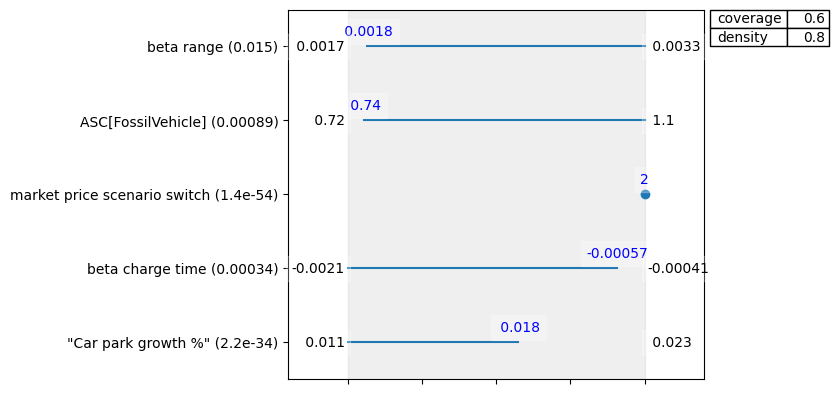

In [42]:
box1.inspect(16)
box1.inspect(16, style='graph')

**Interpretation**
* coverage = 0.6, Density = 0.8 → Good balance: captures 60% of low-EV cases with 80% purity.

Restricted variables:

* β range (0.0017–0.0033)
→ EV adoption is low when the sensitivity to driving range is weak — i.e. consumers don’t value range strongly.

* ASC[FossilVehicle] (0.72–1.1)
→ High positive ASC for fossil vehicles — meaning ICE cars are generally more preferred.

* market price scenario switch = 2
→ This discrete variable = likely a high-price or unfavourable market scenario.

* β charge time (-0.0021 to -0.00057)
→ Low absolute effect of charge time — people not penalising charging delay strongly (or in other words, EV inconvenience is not mitigated).

* Car park growth % (0.011–0.023)
→ Relatively high growth in total vehicles, meaning fast expansion of the fleet where EV share stays small.

**Interpretation for stakeholder**

Low EV adoption occurs in model when:

* ICEs remain relatively attractive (ASC[FossilVehicle] high),
* range matters little to consumers (β range small),
* charging time penalty is small (β charge time close to zero → limited sensitivity to charging inconvenience),
* total car park is expanding fast (growth 1.1–2.3%),
* and this happens mainly under market scenario 2.


"The PRIM analysis reveals that low EV adoption occurs primarily when internal-combustion vehicles retain a high intrinsic preference (ASC[FossilVehicle] > 0.7), consumers place limited importance on EV range and charging time (β range ≈ 0.002, β charge time ≈ −0.001), and the vehicle fleet grows rapidly (1.1–2.3 %/yr), particularly under market price scenario 2.
Box 16 (coverage = 0.6, density = 0.8) offers the best trade-off between explanatory power and representativeness.[EXPLAIN WHY]"

#### HIGH EV SCENARIO

In [44]:
x = experiments

ev_ts = outcomes["Number of EVs"]
final_evs = ev_ts[:, -1] # pick the last time step (or the column == 30 if your columns are time labels)

cutoff_hi = np.percentile(final_evs, 80)   # 20th percentile
y = final_evs > cutoff_hi                  # explicitly asking PRIM to find combinations of inputs that characterise low EV adoption scenarios.

In [45]:
prim_alg = prim.Prim(x, y, threshold=0.8)
box1 = prim_alg.find_box()

[MainProcess/INFO] column model dropped from analysis because it has only one category
[MainProcess/INFO] 2400 points remaining, containing 480 cases of interest
[MainProcess/INFO] mean: 0.88, mass: 0.08333333333333333, coverage: 0.36666666666666664, density: 0.88 restricted_dimensions: 8


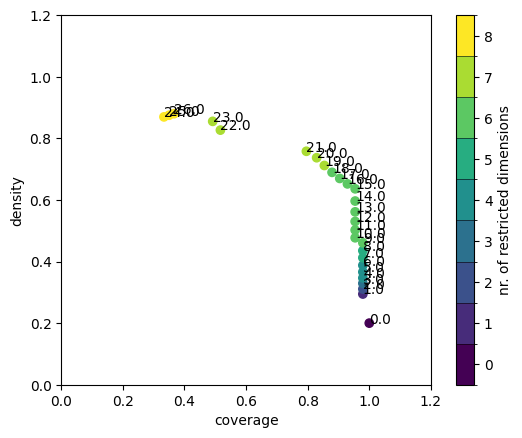

In [46]:
box1.show_tradeoff(annotated=True)
plt.show()

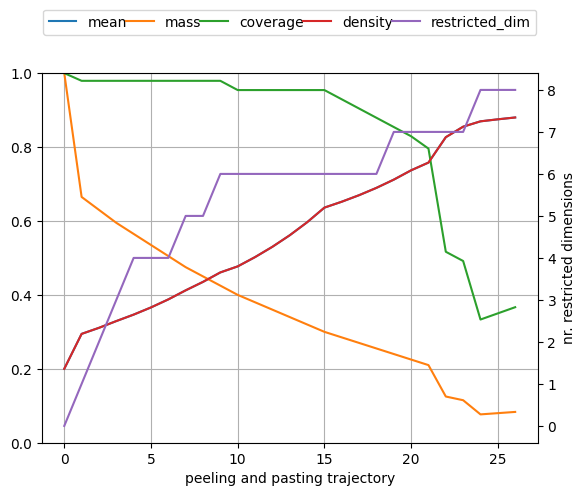

In [47]:
box1.show_ppt() ;

''

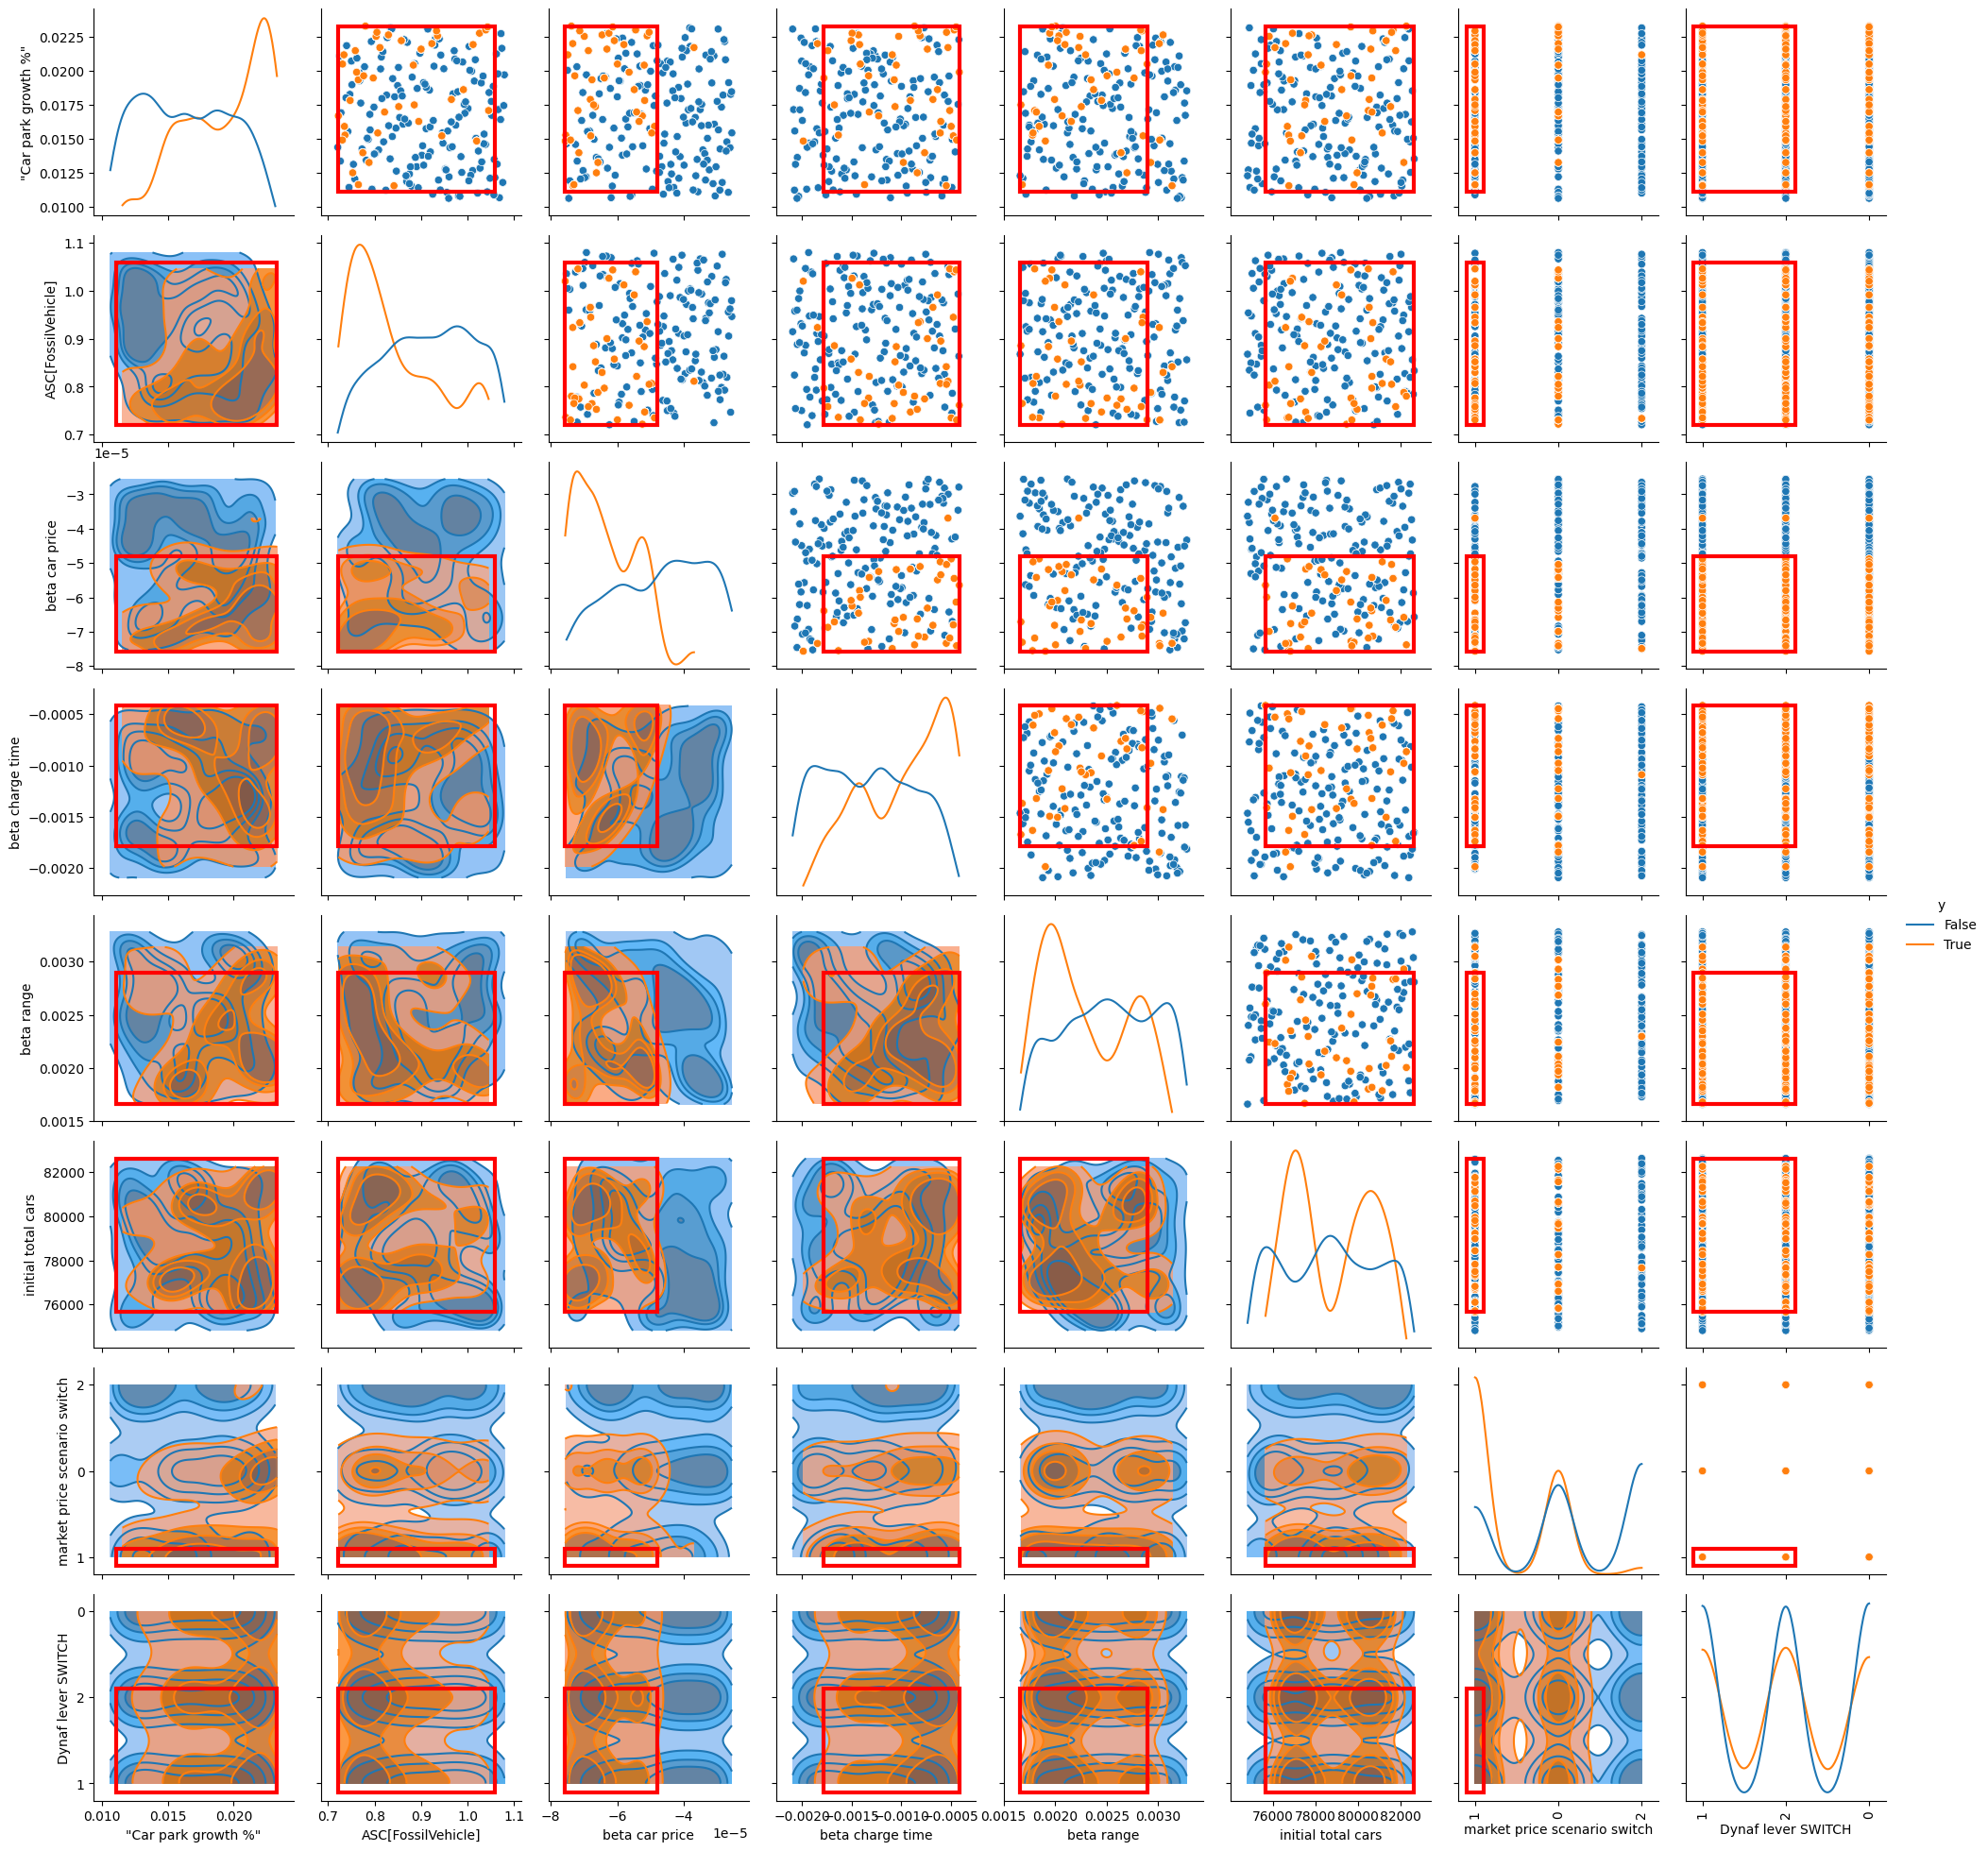

In [48]:
# Scatter plot of box boundaries, for n=2400 takes ~ 1 min
box1.show_pairs_scatter()        # visualize relationships inside/outside box
;

coverage      0.516667
density       0.826667
id           22.000000
k           248.000000
mass          0.125000
mean          0.826667
n           300.000000
res_dim       7.000000
Name: 22, dtype: float64

                                box 22                                      
                                   min       max      qp value      qp value
beta car price               -0.000076  -0.00005           NaN  8.726861e-22
beta range                     0.00166  0.002914           NaN  6.658702e-05
ASC[FossilVehicle]            0.720786  1.057771           NaN  5.369587e-01
market price scenario switch       {1}       {1}  1.263055e-23           NaN
"Car park growth %"           0.011091  0.023283  9.631055e-02           NaN
beta charge time             -0.001784 -0.000414  1.635730e-01           NaN
initial total cars               75652     82630  5.369587e-01           NaN



c:\Users\Amber Rozenberg\anaconda3\envs\cura_ev_env\Lib\site-packages\ema_workbench\analysis\prim.py:501: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '{1}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  box_lim.loc[unc] = values.values.tolist() + qp_values[unc]
c:\Users\Amber Rozenberg\anaconda3\envs\cura_ev_env\Lib\site-packages\ema_workbench\analysis\prim.py:501: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '{1}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  box_lim.loc[unc] = values.values.tolist() + qp_values[unc]


[<Figure size 640x480 with 1 Axes>]

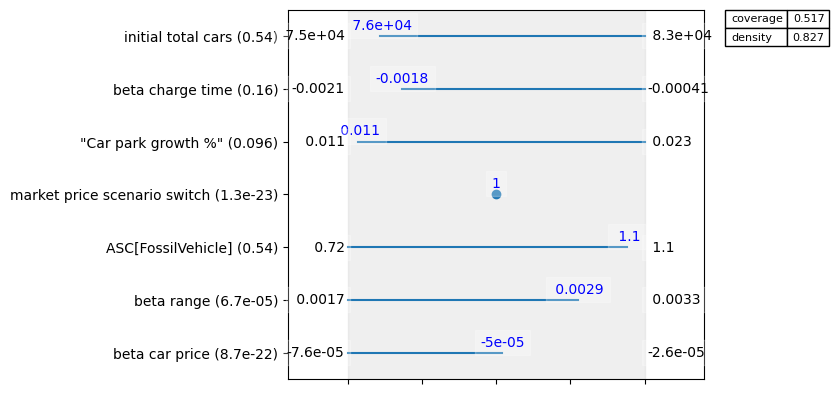

In [49]:
# insoect the 'elbow' box
box1.inspect(22)
box1.inspect(22, style='graph')

**Interpretation**
Coverage = 0.52, Density = 0.83 → Good balance: the box captures ≈ 52 % of all high-EV cases with ≈ 83 % purity.

Restricted variables:
* β car price (–7.6 × 10⁻⁵ to –2.6 × 10⁻⁵)
→ Consumers are relatively insensitive to purchase price; price differences no longer strongly affect EV adoption.
* β range (0.0017 – 0.0029)
→ High sensitivity to range — people value driving range strongly, so improvements in range have a big positive impact.
* ASC [FossilVehicle] (0.72 – 1.10)
→ Internal-combustion vehicles remain acceptable but are not overwhelmingly preferred, leaving room for EV uptake.
* Market price scenario switch = 1
→ High EV adoption occurs mainly under a favourable market scenario (e.g. stable prices, supportive policy climate).
* Car park growth % (0.011 – 0.023)
→ Moderate fleet growth — the total number of vehicles increases, but EVs gain a large share within that expansion.
* β charge time (–0.0018 – –0.0004)
→ Moderate disutility for charging time — consumers dislike long charging, yet infrastructure is sufficient to keep it manageable.
* Initial total cars (7.6 × 10⁴ – 8.3 × 10⁴)
→ High adoption emerges in markets that already have a relatively large vehicle base, suggesting maturity and readiness to scale EVs.

**Interpretation for stakeholders**
* High EV adoption occurs in the model when:
* Market conditions are favourable (scenario 1),
* Consumers value driving range strongly (β range high),
* Price sensitivity is low (β car price weak),
* Charging inconvenience is tolerable thanks to adequate infrastructure,
* ICE cars are no longer heavily preferred, and
* The vehicle fleet grows steadily (≈ 1.1 – 2.3 % per year).

""The PRIM analysis reveals that widespread EV uptake emerges under supportive market conditions where consumers trust EV technology and charging reliability. Price incentives play a secondary role once these fundamentals are in place.
Box 22 (coverage ≈ 0.52, density ≈ 0.83) offers the best trade-off between explanatory power and representativeness: it explains a large share of high-adoption outcomes while remaining general enough to describe realistic, policy-relevant conditions.""

Why this box was chosen:
Box 22 strikes the balance between coverage (capturing over half of all high-EV cases) and density (limited false positives). Later boxes (e.g. 23–26) gain little additional purity but lose too much generality, describing only a narrow subset of runs.

### Plot some nice lines on scenarios

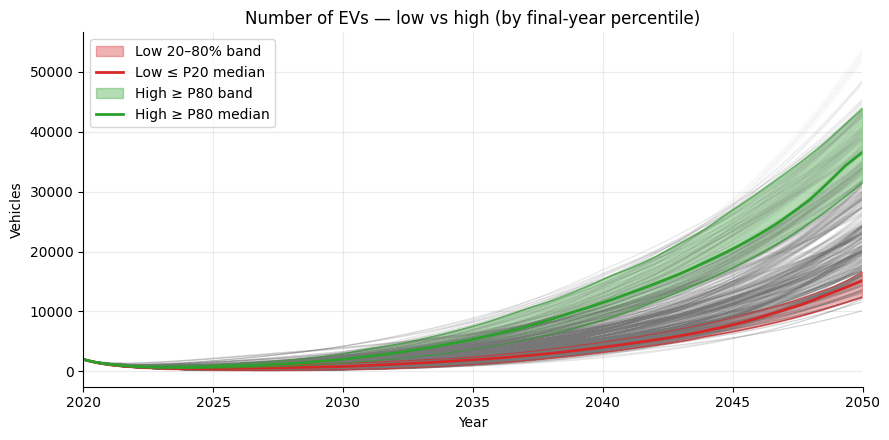

In [54]:
# --- helper from your code ---
def _make_time_axis_from_outcome(arr):
    T = arr.shape[1]
    for key in ("time", "TIME", "Time"):
        if key in outcomes and getattr(outcomes[key], "ndim", None) == 1 and outcomes[key].shape[0] == T:
            return outcomes[key]
    return np.linspace(2020, 2050, T)

def plot_ev_low_high_percentiles(outcomes,
                                 outcome_name="Number of EVs",
                                 low_q=20, high_q=80,
                                 upsample_factor=8,
                                 show_bands=True,
                                 band_quantiles=(10, 90),
                                 all_runs_alpha=0.03,
                                 all_runs_lw=0.7,
                                 low_colour="#d62728",   # red-ish
                                 high_colour="#2ca02c",  # green-ish
                                 median_lw=2.0,
                                 figsize=(9, 4.5)):
    """
    Plot EV adoption with low/high groups (based on final-year EV count) in different colours.
    - low group: runs with final EVs <= low_q percentile
    - high group: runs with final EVs >= high_q percentile
    """
    if outcome_name not in outcomes:
        raise KeyError(f"Outcome '{outcome_name}' not found in outcomes dict")

    arr = outcomes[outcome_name]                     # shape (n_cases, T)
    if arr.ndim != 2:
        raise ValueError(f"'{outcome_name}' must be 2D (n_cases, T); got {arr.shape}")

    n_cases, T = arr.shape
    time = _make_time_axis_from_outcome(arr)

    # define low/high groups by FINAL time step (same as PRIM)
    final_vals = arr[:, -1].astype(float)
    low_cut  = np.percentile(final_vals, low_q)
    high_cut = np.percentile(final_vals, high_q)
    low_mask  = final_vals <= low_cut
    high_mask = final_vals >= high_cut

    # interpolation grid
    fine_T = int(T * upsample_factor)
    fine_time = np.linspace(time[0], time[-1], fine_T)

    # helper to upsample an array of runs (N,T) -> (N,fine_T)
    def _interp_runs(A):
        Y = np.empty((A.shape[0], fine_T), dtype=float)
        for i in range(A.shape[0]):
            Y[i] = np.interp(fine_time, time, A[i].astype(float))
        return Y

    A_all  = _interp_runs(arr)
    A_low  = _interp_runs(arr[low_mask, :])
    A_high = _interp_runs(arr[high_mask, :])

    # percentile bands per group (optional)
    def _band(Y, qlo, qhi):
        return (np.nanpercentile(Y, qlo, axis=0), np.nanpercentile(Y, qhi, axis=0))

    fig, ax = plt.subplots(figsize=figsize)

    # faint background of all runs (grey)
    for i in range(A_all.shape[0]):
        ax.plot(fine_time, A_all[i], color="#777777", alpha=all_runs_alpha, 
                linewidth=all_runs_lw)

    # LOW group band + median
    if show_bands and A_low.shape[0] > 0:
        lo_band, hi_band = _band(A_low, band_quantiles[0], band_quantiles[1])
        ax.fill_between(fine_time, lo_band, hi_band, alpha=0.35, step=None, color=low_colour, 
                        label=f"Low {low_q}–{100-low_q}% band", zorder=1)  # added here
        
        # outline the band to increase contrast
        ax.plot(fine_time, lo_band, color=low_colour, linewidth=0.8, alpha=0.7, zorder=2)
        ax.plot(fine_time, hi_band, color=low_colour, linewidth=0.8, alpha=0.7, zorder=2)


    if A_low.shape[0] > 0:
        low_med = np.nanmedian(A_low, axis=0)
        ax.plot(fine_time, low_med, color=low_colour, linewidth=median_lw, 
                label=f"Low ≤ P{low_q} median")

    # HIGH group band + median
    if show_bands and A_high.shape[0] > 0:
        lo_band_h, hi_band_h = _band(A_high, band_quantiles[0], band_quantiles[1])
        ax.fill_between(fine_time, lo_band_h, hi_band_h, alpha=0.35, step=None, 
                        color=high_colour, label=f"High ≥ P{high_q} band")
        
        # outline the band to increase contrast
        ax.plot(fine_time, lo_band_h, color=high_colour, linewidth=0.8, alpha=0.7, zorder=2)
        ax.plot(fine_time, hi_band_h, color=high_colour, linewidth=0.8, alpha=0.7, zorder=2)


    if A_high.shape[0] > 0:
        high_med = np.nanmedian(A_high, axis=0)
        ax.plot(fine_time, high_med, color=high_colour, linewidth=median_lw, 
                label=f"High ≥ P{high_q} median")

    # styling
    ax.set_title(f"{outcome_name} — low vs high (by final-year percentile)")
    ax.set_xlabel("Year")
    ax.set_ylabel("Vehicles")
    ax.set_xlim(time[0], time[-1])
    try:
        ax.set_xticks(np.arange(2020, 2051, 5))
    except Exception:
        pass
    ax.grid(alpha=0.25)
    ax.legend(loc="upper left")
    sns.despine()
    plt.tight_layout()
    plt.show()

# --- call for EV adoption, using your same outcome dict ---
plot_ev_low_high_percentiles(outcomes,
                             outcome_name="Number of EVs",
                             low_q=20, high_q=80,
                             upsample_factor=8,
                             show_bands=True)


**⚪ Grey lines**

* All 2 400 model runs — every unique combination of uncertainty and policy you explored.
* They show the full variability of possible EV trajectories (2020–2050).

**🔴 Red band + line**

* Subset: the lowest 20 % of final-year EV outcomes (the low-adoption scenarios you used for PRIM).

* Red line: median EV trajectory within that subset.

* Light red band: 10th–90th percentile range within that subset → captures variability inside low-EV cases.
So it’s not the overall 20–80 % of all data, but the internal spread among the bottom quintile.

**🟢 Green band + line**

* Subset: the highest 20 % of final-year EV outcomes (the high-adoption scenarios used in your second PRIM).

* Green line: median EV trajectory of these top performers.

**What do the lines and colours mean?**
* The width of each band = variability within the group → more width means internal heterogeneity.
* The gap between bands = difference between structural futures 
* You can directly link the PRIM boxes to these coloured groups:
*  Red ↔ conditions like high ASC[FossilVehicle], unfavourable market (Box 16).
* Green ↔ favourable market, strong β range, low price sensitivity (Box 22).

**Interpretation**
* The vertical distance between the green and red medians shows how much the future adoption paths diverge by 2050 — a measure of the uncertainty or scenario spread.
* Early years (2020–2030) overlap strongly → the system behaves similarly at first, independent of assumptions.
* Around 2030–2040, the bands separate — that’s when different parameter/policy combinations start to have strong effects (e.g. policy switches, consumer preferences, infrastructure growth).
* By 2045–2050, trajectories differ dramatically: the red group flattens at low adoption, while the green group accelerates exponentially.
→ That’s the emergence of structurally different futures your PRIM boxes describe.

**For Report**
igure X compares the evolution of EV adoption for the lower and upper 20 % of outcomes.
Until roughly 2030, trajectories are similar across runs, indicating limited sensitivity to parameter and policy differences in the early phase of diffusion.
From 2035 onward, scenarios diverge: in the low-adoption group (red), growth remains modest and plateaus below ~10 000 vehicles, whereas the high-adoption group (green) continues rising sharply, reaching over 40 000 vehicles by 2050.
The shaded bands represent the internal uncertainty within each group (10th–90th percentile). Their widening over time reflects increasing divergence among plausible futures.